# 0. Data Preparation: LIDC-IDRI to 3D Patches (v2 – Real Masks)

This notebook processes the LIDC-IDRI dataset to create training data for the 3D UNet.

**Fixes over v1:**
- Extracts **actual X/Y coordinates** from XML EdgeMap contours (not just Z).
- Generates **real segmentation masks** from ROI contour polygons via `cv2.fillPoly`.
- Centers patches on the **true nodule centroid** instead of the image center.
- Clusters annotations across radiologist sessions by `noduleID` proximity.

**Pipeline:**
1. Scan DICOM series and XML annotations.
2. Parse ALL ROIs (multiple slices, multiple sessions) with full contour coordinates.
3. Cluster annotations across sessions to form consensus nodules.
4. Resample CT to 1mm isotropic spacing.
5. Build 3D binary mask from contour polygons.
6. Extract 64×64×64 patches centered on nodule centroid.
7. Save as `.npz` files with keys: `image`, `mask`, `label`, `malignancy`.

In [1]:
import os
import glob
import numpy as np
import pydicom
import scipy.ndimage
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import cv2
import sys

# Configuration
LIDC_PATH = Path(r"C:\Users\padal\Documents\Work\FYP-1\LIDC-IDRI")
OUTPUT_PATH = Path("../data/lidc_patches")
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

PATCH_SIZE = 64
TARGET_SPACING = np.array([1.0, 1.0, 1.0])
CLUSTER_DIST_MM = 30  # Max distance (mm) to group annotations as same nodule

print(f"Python: {sys.executable}")
print(f"LIDC Path: {LIDC_PATH}")
print(f"Output Path: {OUTPUT_PATH.resolve()}")

Python: c:\Users\padal\Documents\Work\FYP-1\backend\venv\Scripts\python.exe
LIDC Path: C:\Users\padal\Documents\Work\FYP-1\LIDC-IDRI
Output Path: C:\Users\padal\Documents\Work\FYP-1\backend\ml\data\lidc_patches


## 1. Helper Functions

In [2]:
def load_scan(path):
    """Load DICOM series, filtering out files without ImagePositionPatient."""
    slices = []
    for s in glob.glob(str(path / "*.dcm")):
        try:
            ds = pydicom.dcmread(s)
            if hasattr(ds, 'ImagePositionPatient'):
                slices.append(ds)
        except:
            continue

    if not slices or len(slices) < 2:
        return None

    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    if slice_thickness == 0:
        slice_thickness = 1.0  # Fallback

    for s in slices:
        s.SliceThickness = slice_thickness

    return slices


def get_pixels_hu(slices):
    """Convert DICOM pixel data to Hounsfield Units."""
    image = np.stack([s.pixel_array for s in slices])
    image = image.astype(np.int16)
    intercept = slices[0].RescaleIntercept
    slope = slices[0].RescaleSlope
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
    image += np.int16(intercept)
    return np.array(image, dtype=np.int16)


def resample(image, scan, new_spacing=TARGET_SPACING):
    """Resample 3D volume to isotropic spacing."""
    spacing = np.array([
        scan[0].SliceThickness,
        scan[0].PixelSpacing[0],
        scan[0].PixelSpacing[1]
    ], dtype=np.float32)
    resize_factor = spacing / new_spacing
    new_shape = np.round(image.shape * resize_factor).astype(int)
    real_resize_factor = new_shape / image.shape
    image = scipy.ndimage.zoom(image, real_resize_factor, mode='nearest')
    return image, spacing, real_resize_factor

## 2. XML Parsing – Full Contour Extraction

In [3]:
def parse_xml_full(xml_path):
    """Parse LIDC XML and extract ALL ROI contours with X/Y/Z coordinates.
    
    Returns a list of nodule annotations, each with:
      - nodule_id: str
      - malignancy: int (1-5, 0 if missing)
      - rois: list of {z_pos, contour_points [(x,y), ...]}
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()
    ns = '{http://www.nih.gov}'
    
    annotations = []
    
    for session in root.findall(f'{ns}readingSession'):
        for unblinded in session.findall(f'{ns}unblindedReadNodule'):
            nod_id_elem = unblinded.find(f'{ns}noduleID')
            nod_id = nod_id_elem.text.strip() if nod_id_elem is not None else 'unknown'
            
            # Malignancy
            mal_elem = unblinded.find(f'{ns}characteristics/{ns}malignancy')
            malignancy = int(mal_elem.text) if mal_elem is not None else 0
            
            # Parse all ROIs (one per slice)
            rois = []
            for roi in unblinded.findall(f'{ns}roi'):
                z_elem = roi.find(f'{ns}imageZposition')
                if z_elem is None:
                    continue
                z_pos = float(z_elem.text)
                
                # Extract edgeMap contour points
                contour = []
                for em in roi.findall(f'{ns}edgeMap'):
                    x = int(em.find(f'{ns}xCoord').text)
                    y = int(em.find(f'{ns}yCoord').text)
                    contour.append((x, y))
                
                if len(contour) >= 1:
                    rois.append({
                        'z_pos': z_pos,
                        'contour': contour
                    })
            
            if rois:
                annotations.append({
                    'nodule_id': nod_id,
                    'malignancy': malignancy,
                    'rois': rois
                })
    
    return annotations


def cluster_annotations(annotations, dist_threshold=CLUSTER_DIST_MM):
    """Cluster annotations across radiologist sessions by spatial proximity.
    
    Multiple radiologists annotate the same nodule with different IDs.
    We group them by centroid distance.
    
    Returns list of consensus nodules, each with merged ROIs and avg malignancy.
    """
    # Compute centroid for each annotation
    centroids = []
    for ann in annotations:
        all_x, all_y, all_z = [], [], []
        for roi in ann['rois']:
            all_z.append(roi['z_pos'])
            for (x, y) in roi['contour']:
                all_x.append(x)
                all_y.append(y)
        centroids.append((np.mean(all_x), np.mean(all_y), np.mean(all_z)))
    
    # Simple greedy clustering
    used = set()
    clusters = []
    
    for i in range(len(annotations)):
        if i in used:
            continue
        cluster = [i]
        used.add(i)
        for j in range(i+1, len(annotations)):
            if j in used:
                continue
            dist = np.sqrt(sum((a-b)**2 for a,b in zip(centroids[i], centroids[j])))
            if dist < dist_threshold:
                cluster.append(j)
                used.add(j)
        clusters.append(cluster)
    
    # Merge clusters into consensus nodules
    consensus = []
    for cluster_ids in clusters:
        merged_rois = []
        malignancies = []
        for idx in cluster_ids:
            ann = annotations[idx]
            merged_rois.extend(ann['rois'])
            if ann['malignancy'] > 0:
                malignancies.append(ann['malignancy'])
        
        avg_mal = int(round(np.mean(malignancies))) if malignancies else 0
        consensus.append({
            'agreement': len(cluster_ids),
            'malignancy': avg_mal,
            'rois': merged_rois
        })
    
    return consensus

print("XML parsing functions defined.")

XML parsing functions defined.


## 3. Mask Generation & Patch Extraction

In [4]:
def build_nodule_mask(nodule, slices, image_shape, pixel_spacing):
    """Build a 3D binary mask from ROI contour polygons.
    
    Args:
        nodule: consensus nodule dict with 'rois'
        slices: sorted DICOM slices
        image_shape: (Z, Y, X) shape of original volume
        pixel_spacing: (row_spacing, col_spacing)
    
    Returns:
        mask_3d: binary mask (Z,Y,X)
        centroid: (cz, cy, cx) in voxel coordinates
    """
    mask_3d = np.zeros(image_shape, dtype=np.uint8)
    
    # Build Z-position to slice-index lookup
    z_positions = [float(s.ImagePositionPatient[2]) for s in slices]
    
    filled_slices = []
    
    for roi in nodule['rois']:
        z_pos = roi['z_pos']
        contour = roi['contour']
        
        if len(contour) < 3:
            # Single point or line – mark a small region
            z_idx = np.argmin(np.abs(np.array(z_positions) - z_pos))
            for (x, y) in contour:
                if 0 <= y < image_shape[1] and 0 <= x < image_shape[2]:
                    mask_3d[z_idx, y, x] = 1
            filled_slices.append((z_idx, contour))
            continue
        
        # Find closest slice index
        z_idx = np.argmin(np.abs(np.array(z_positions) - z_pos))
        
        # Convert contour to polygon and fill
        poly = np.array(contour, dtype=np.int32)  # (N, 2) as (x, y)
        # cv2.fillPoly expects (N, 1, 2) with (x, y) order
        poly = poly.reshape((-1, 1, 2))
        
        slice_mask = np.zeros((image_shape[1], image_shape[2]), dtype=np.uint8)
        cv2.fillPoly(slice_mask, [poly], 1)
        mask_3d[z_idx] = np.maximum(mask_3d[z_idx], slice_mask)
        filled_slices.append((z_idx, contour))
    
    # Compute centroid from all contour points
    all_z, all_y, all_x = [], [], []
    for (z_idx, contour) in filled_slices:
        for (x, y) in contour:
            all_z.append(z_idx)
            all_y.append(y)
            all_x.append(x)
    
    if not all_z:
        return None, None
    
    centroid = (int(np.mean(all_z)), int(np.mean(all_y)), int(np.mean(all_x)))
    return mask_3d, centroid


def extract_patch(volume, mask, centroid, patch_size=PATCH_SIZE):
    """Extract a patch_size^3 patch centered on centroid from both volume and mask.
    
    Handles boundary padding if centroid is near edges.
    """
    cz, cy, cx = centroid
    half = patch_size // 2
    
    # Compute start/end with clamping
    z_start = max(0, cz - half)
    y_start = max(0, cy - half)
    x_start = max(0, cx - half)
    
    z_end = z_start + patch_size
    y_end = y_start + patch_size
    x_end = x_start + patch_size
    
    # Adjust if we exceed volume bounds
    if z_end > volume.shape[0]:
        z_end = volume.shape[0]
        z_start = max(0, z_end - patch_size)
    if y_end > volume.shape[1]:
        y_end = volume.shape[1]
        y_start = max(0, y_end - patch_size)
    if x_end > volume.shape[2]:
        x_end = volume.shape[2]
        x_start = max(0, x_end - patch_size)
    
    img_patch = volume[z_start:z_end, y_start:y_end, x_start:x_end]
    msk_patch = mask[z_start:z_end, y_start:y_end, x_start:x_end]
    
    # If still too small (volume smaller than patch_size), pad with zeros
    if img_patch.shape != (patch_size, patch_size, patch_size):
        padded_img = np.full((patch_size, patch_size, patch_size), -1000, dtype=img_patch.dtype)
        padded_msk = np.zeros((patch_size, patch_size, patch_size), dtype=msk_patch.dtype)
        sz, sy, sx = img_patch.shape
        padded_img[:sz, :sy, :sx] = img_patch
        padded_msk[:sz, :sy, :sx] = msk_patch
        img_patch = padded_img
        msk_patch = padded_msk
    
    return img_patch, msk_patch

print("Mask and patch extraction functions defined.")

Mask and patch extraction functions defined.


## 4. Main Processing Function

In [5]:
def process_scan_v2(series_path, scan_id):
    """Process a single DICOM series: load CT, parse XML, build masks, extract patches."""
    results = []
    try:
        # 1. Load CT
        slices = load_scan(series_path)
        if slices is None:
            return results
        
        image = get_pixels_hu(slices)
        pixel_spacing = (float(slices[0].PixelSpacing[0]), float(slices[0].PixelSpacing[1]))
        
        # 2. Find XML
        xml_files = list(series_path.parent.glob("*.xml"))
        if not xml_files:
            xml_files = list(series_path.glob("*.xml"))
        if not xml_files:
            return results
        
        # 3. Parse annotations with full contour data
        annotations = parse_xml_full(xml_files[0])
        if not annotations:
            return results
        
        # 4. Cluster across sessions
        consensus_nodules = cluster_annotations(annotations)
        
        # 5. Process each consensus nodule
        for nod_idx, nodule in enumerate(consensus_nodules):
            # Skip nodules with malignancy=0 (no characteristics data)
            if nodule['malignancy'] == 0:
                continue
            
            # Build 3D mask on original-resolution volume
            mask_3d, centroid = build_nodule_mask(nodule, slices, image.shape, pixel_spacing)
            if mask_3d is None or centroid is None:
                continue
            
            # Check mask has actual content
            mask_voxels = np.sum(mask_3d > 0)
            if mask_voxels < 3:
                continue  # Skip tiny annotations (likely non-nodule)
            
            # 6. Resample both image and mask
            image_resampled, orig_spacing, resize_factor = resample(image, slices)
            # Resample mask with nearest-neighbor to preserve binary values
            mask_resampled = scipy.ndimage.zoom(mask_3d.astype(np.float32), resize_factor, mode='nearest')
            mask_resampled = (mask_resampled > 0.5).astype(np.float32)
            
            # Recompute centroid after resampling
            cz_r = int(centroid[0] * resize_factor[0])
            cy_r = int(centroid[1] * resize_factor[1])
            cx_r = int(centroid[2] * resize_factor[2])
            centroid_r = (cz_r, cy_r, cx_r)
            
            # 7. Extract patch
            img_patch, msk_patch = extract_patch(image_resampled, mask_resampled, centroid_r)
            
            # Verify mask is still present in patch
            if np.sum(msk_patch > 0) < 1:
                continue
            
            # 8. Save
            label = 1 if nodule['malignancy'] > 3 else 0
            out_name = OUTPUT_PATH / f"{scan_id}_nodule_{nod_idx}.npz"
            np.savez_compressed(out_name,
                image=img_patch,
                mask=msk_patch,
                label=label,
                malignancy=nodule['malignancy']
            )
            results.append({
                'file': str(out_name),
                'mask_voxels': int(np.sum(msk_patch > 0)),
                'malignancy': nodule['malignancy'],
                'label': label,
                'agreement': nodule['agreement']
            })
    
    except Exception as e:
        print(f"Error processing {scan_id}: {e}")
    
    return results

print("Processing function defined.")

Processing function defined.


## 5. Execution Loop

In [6]:
def find_dicom_series(root_path):
    """Find all directories containing DICOM files."""
    series_paths = []
    for root, dirs, files in os.walk(root_path):
        if any(f.endswith('.dcm') for f in files):
            series_paths.append(Path(root))
    return series_paths

# Clear old patches
old_patches = glob.glob(str(OUTPUT_PATH / "*.npz"))
print(f"Removing {len(old_patches)} old patches...")
for f in old_patches:
    os.remove(f)

# Find all series
series_list = find_dicom_series(LIDC_PATH)
print(f"Found {len(series_list)} DICOM series.")

# Process all
all_results = []
for path in tqdm(series_list, desc="Processing scans"):
    scan_id = path.parent.name
    results = process_scan_v2(path, scan_id)
    all_results.extend(results)

print(f"\n{'='*50}")
print(f"Total patches extracted: {len(all_results)}")
if all_results:
    labels = [r['label'] for r in all_results]
    print(f"Malignant (label=1): {sum(labels)}")
    print(f"Benign (label=0): {len(labels) - sum(labels)}")
    mask_sizes = [r['mask_voxels'] for r in all_results]
    print(f"Mask voxel counts: min={min(mask_sizes)}, max={max(mask_sizes)}, mean={np.mean(mask_sizes):.0f}")

Removing 147 old patches...
Found 558 DICOM series.


Processing scans: 100%|██████████| 558/558 [35:31<00:00,  3.82s/it]  


Total patches extracted: 83
Malignant (label=1): 24
Benign (label=0): 59
Mask voxel counts: min=63, max=16839, mean=1961


## 6. Validation: Visualize Extracted Patches

Total patches on disk: 83


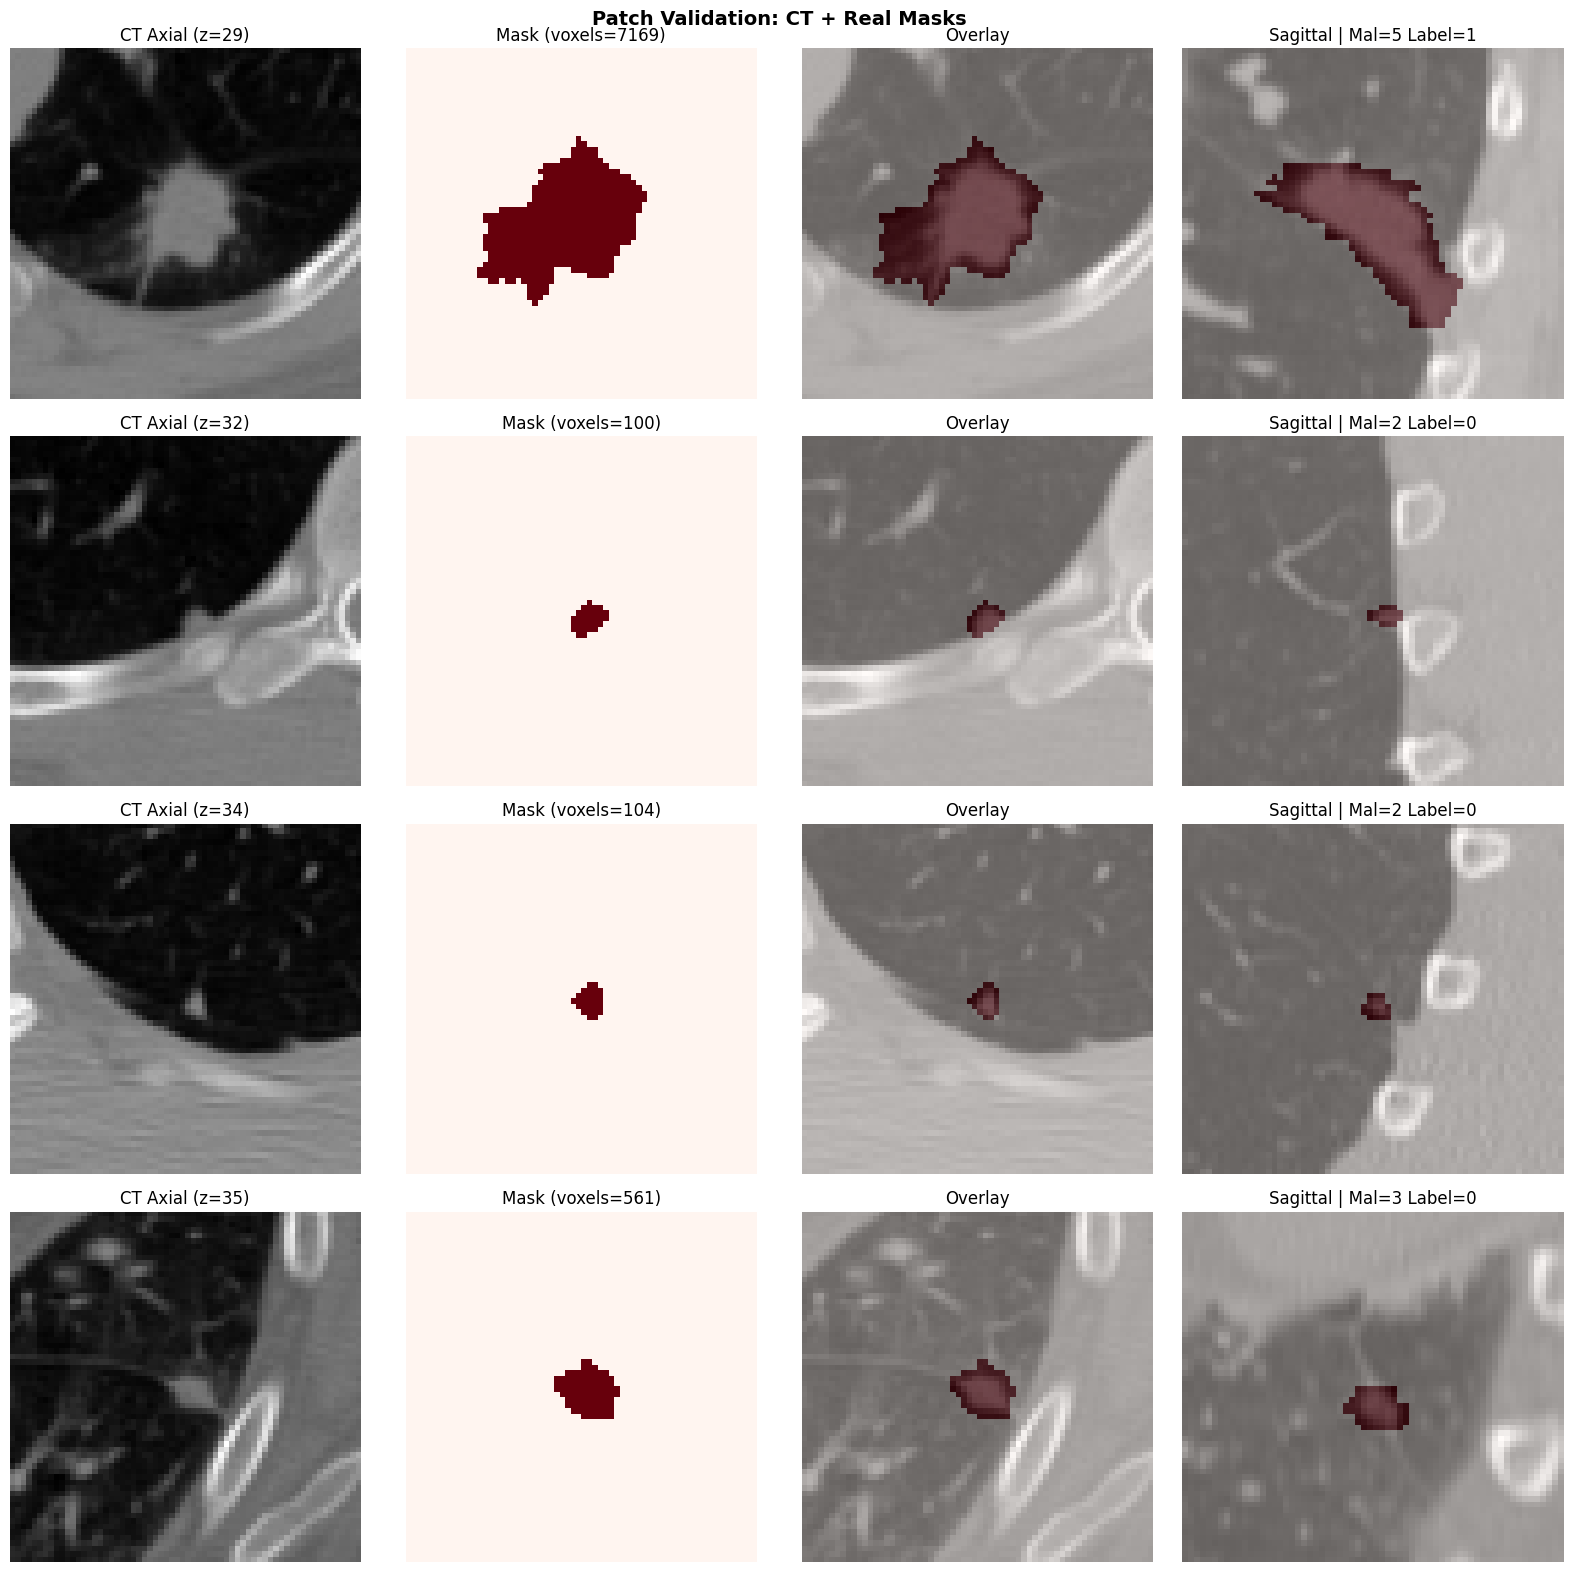


Integrity: 83/83 patches have valid masks.


: 

In [ ]:
# Load and visualize a few patches to confirm quality
patch_files = sorted(glob.glob(str(OUTPUT_PATH / "*.npz")))
print(f"Total patches on disk: {len(patch_files)}")

n_show = min(4, len(patch_files))
fig, axes = plt.subplots(n_show, 4, figsize=(16, 4*n_show))
if n_show == 1:
    axes = axes[np.newaxis, :]

for i in range(n_show):
    data = np.load(patch_files[i])
    img = data['image']
    msk = data['mask']
    label = data['label']
    mal = data['malignancy']
    
    # Find the slice with the most mask content
    slice_sums = np.sum(msk, axis=(1,2))
    best_z = np.argmax(slice_sums)
    
    axes[i, 0].imshow(img[best_z], cmap='gray')
    axes[i, 0].set_title(f'CT Axial (z={best_z})')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(msk[best_z], cmap='Reds')
    axes[i, 1].set_title(f'Mask (voxels={int(np.sum(msk))})')
    axes[i, 1].axis('off')
    
    # Overlay
    axes[i, 2].imshow(img[best_z], cmap='gray')
    axes[i, 2].imshow(msk[best_z], cmap='Reds', alpha=0.4)
    axes[i, 2].set_title(f'Overlay')
    axes[i, 2].axis('off')
    
    # Sagittal view
    cx = img.shape[2] // 2
    axes[i, 3].imshow(img[:, :, cx], cmap='gray', aspect='auto')
    axes[i, 3].imshow(msk[:, :, cx], cmap='Reds', alpha=0.4, aspect='auto')
    axes[i, 3].set_title(f'Sagittal | Mal={mal} Label={label}')
    axes[i, 3].axis('off')

plt.suptitle('Patch Validation: CT + Real Masks', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Final integrity check
masks_present = 0
for f in patch_files:
    d = np.load(f)
    if 'mask' in d and np.sum(d['mask']) > 0:
        masks_present += 1
print(f"\nIntegrity: {masks_present}/{len(patch_files)} patches have valid masks.")